In [1]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
import os

## Load data

In [3]:
data = pd.read_pickle('../data/data_proton_photonsum_15_2133.pkl')
print('Loaded: ',  data.shape)
data_cond = pd.read_pickle('../data/data_cond_photonsum_15_2133_15_3273.pkl')
print('Loaded cond: ',  data_cond.shape)

Loaded:  (48714, 56, 30)
Loaded cond:  (48714, 12)


In [4]:
data_cond.drop(columns=['neutron_photon_sum', 'proton_photon_sum'], inplace=True)

In [5]:
data_cond.head()

,Pdg,Energy,Vx,Vy,Vz,Px,Py,Pz,mass,charge
0,2112,3192.38,0.000000e+00,0.000000e+00,0.000000e+00,0.022422,-0.182957,-3192.38,939.565413,0.0
1,2212,3961.55,0.000000e+00,0.000000e+00,0.000000e+00,-0.076487,0.179845,3961.55,938.272081,1.0
2,310,2770.10,1.861170e-17,2.517190e-17,-1.689330e-13,0.305187,0.412760,-2770.10,497.611000,0.0
3,2212,3195.12,0.000000e+00,0.000000e+00,0.000000e+00,0.560528,-0.149980,3195.11,938.272081,1.0
4,2112,1714.07,0.000000e+00,0.000000e+00,0.000000e+00,0.457768,0.145639,-1714.07,939.565413,0.0


### Preprocess data

In [6]:
data = np.float32(np.log(data+1))

In [7]:
# Credits: majerzemilia

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, decomposition, manifold, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tensorflow.keras import layers
import pickle
import time
from numpy import load
from matplotlib import pyplot
import pickle
import argparse

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from tensorflow.compat.v1.keras.layers import Input, Dense, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D,  Concatenate
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Dense, Reshape, Flatten
from tensorflow.compat.v1.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import mse, binary_crossentropy, logcosh
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from scipy.stats import wasserstein_distance
import pandas as pd
from utils.utils import sum_channels_parallel_ as sum_channels_parallel
from sklearn.metrics import mean_absolute_error
from datetime import datetime

2.10.1


In [8]:
DATE_STR = datetime.now().strftime("%d_%m_%Y_%H_%M")

NAME = "model_"+DATE_STR

EXPERIMENT_NAME = f"{DATE_STR}"

print(DATE_STR, NAME, EXPERIMENT_NAME)

07_03_2023_22_21 model_07_03_2023_22_21 07_03_2023_22_21


In [9]:
def save_scales(model_name, scaler_means, scaler_scales):
    out_fnm = f"{model_name}_scales.txt"
    res = "#means"
    for mean_ in scaler_means:
        res += "\n" + str(mean_)
    res += "\n\n#scales"
    for scale_ in scaler_scales:
        res += "\n" + str(scale_)
    with open(f"../models/{out_fnm}", mode="w") as f:
        f.write(res)

In [10]:
#train/test split
x_train, x_test, y_train, y_test, = train_test_split(data, data_cond, test_size=0.2, shuffle=False)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#scale cond data
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
print("cond max", y_train.max(), "min", y_train.min())

#save scales
save_scales("Proton", scaler.mean_, scaler.scale_)

# make tf datasets
dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size=128)
dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size=128)
dataset_with_cond = tf.data.Dataset.zip((dataset,dataset_cond)).shuffle(12800)

val_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size=128)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test).batch(batch_size=128)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset,val_dataset_cond)).shuffle(12800)

(38971, 56, 30) (9743, 56, 30) (38971, 10) (9743, 10)
cond max 22.267750474560664 min -37.89385322476621


In [11]:
############################ Define Models ############################
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


latent_dim = 10
cond_dim = 10
poz_dim = 6


############################ encoder ############################

input_img = Input(shape=[56,30,1],name='input_img')
input_cond = Input(shape=cond_dim,name='input_cond')
x = Conv2D(32, kernel_size=4, strides=2, padding='same')(input_img)
x = Conv2D(64, kernel_size=4, strides=2,padding='same')(x)
x = Conv2D(128, kernel_size=4, strides=2,padding='same')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Flatten()(x)
x = layers.concatenate([input_cond, x])
x = layers.Dense(latent_dim*2, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([input_img, input_cond], [z_mean, z_log_var, z], name="encoder")
encoder.summary()
############################ decoder ############################


x = Input(shape=(latent_dim,))
cond = Input(shape=(cond_dim,))
inputs = Concatenate(axis=1)([x, cond])

g = Dense(7*4*128)(inputs)
g = Reshape((7,4,128))(g)

g = UpSampling2D()(g)
g = Conv2D(128, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(64, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

g = UpSampling2D()(g)
g = Conv2D(32, kernel_size=4, padding='same')(g)
g = BatchNormalization()(g)
g = LeakyReLU(alpha=0)(g)

outputs = Conv2D(1, kernel_size=(1,3) ,activation='relu')(g)

generator = Model([x, cond], outputs, name='generator')
generator.summary()


# define losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
d_acc_r = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
d_acc_f = keras.metrics.BinaryAccuracy(name="d_acc_r", threshold=0.5)
g_acc = keras.metrics.BinaryAccuracy(name="g_acc_g", threshold=0.5)

# define optimizer
vae_optimizer = tf.keras.optimizers.RMSprop(1e-4)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 56, 30, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 15, 32)   544         ['input_img[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 8, 64)    32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 4, 128)    131200      ['conv2d_1[0][0]']               
                                                                                            

In [17]:
#trainin params

EPOCHS = 10
noise_dim = 10
num_examples_to_generate = 16

# Seed to reuse for generating samples for comparison during training
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = y_test[:num_examples_to_generate]


### function to calculate ws distance between orginal and generated channels
org=np.exp(x_test)-1
ch_org = org.reshape(-1,56,30)
ch_org = pd.DataFrame(sum_channels_parallel(ch_org)).values
del org

(9743, 56, 30)


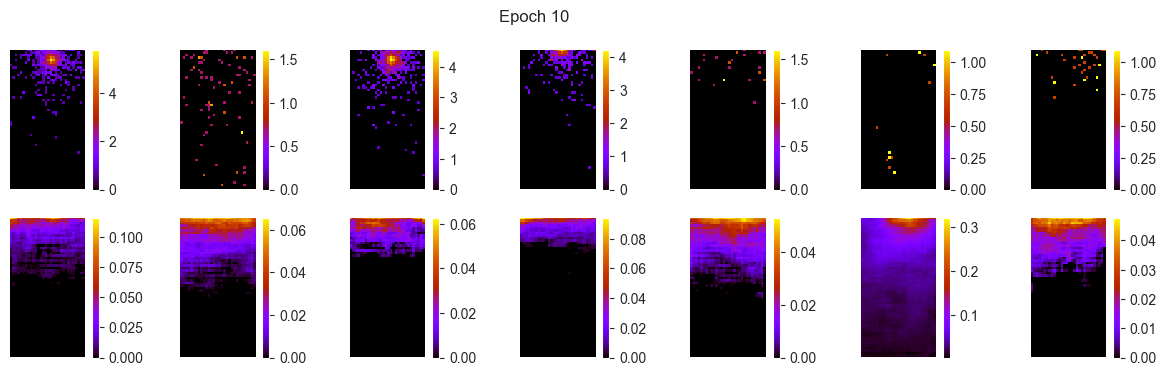

100 [Total loss: 45.30] [Recon_loss: 44.12] [KL loss: 1.68]
200 [Total loss: 40.77] [Recon_loss: 39.78] [KL loss: 1.41]
300 [Total loss: 47.45] [Recon_loss: 46.18] [KL loss: 1.81]


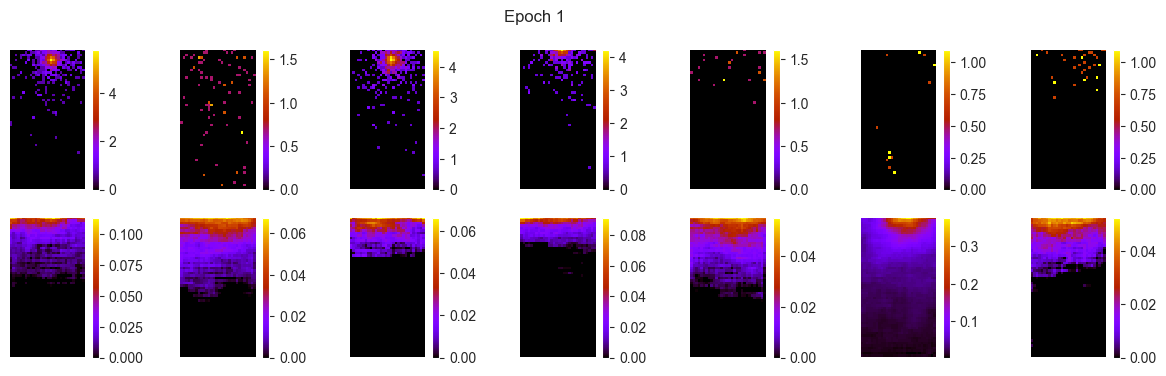

305/305 [==============================] - 3s 9ms/step
(9743, 56, 30)
ws mean 28.68 ch1 0.02 ch2 6.11 ch3 0.30 ch4 65.24 ch5 71.75 Time for epoch 1 is 30.502830028533936 sec
400 [Total loss: 46.76] [Recon_loss: 45.55] [KL loss: 1.73]
500 [Total loss: 43.38] [Recon_loss: 42.40] [KL loss: 1.41]
600 [Total loss: 35.58] [Recon_loss: 34.85] [KL loss: 1.04]


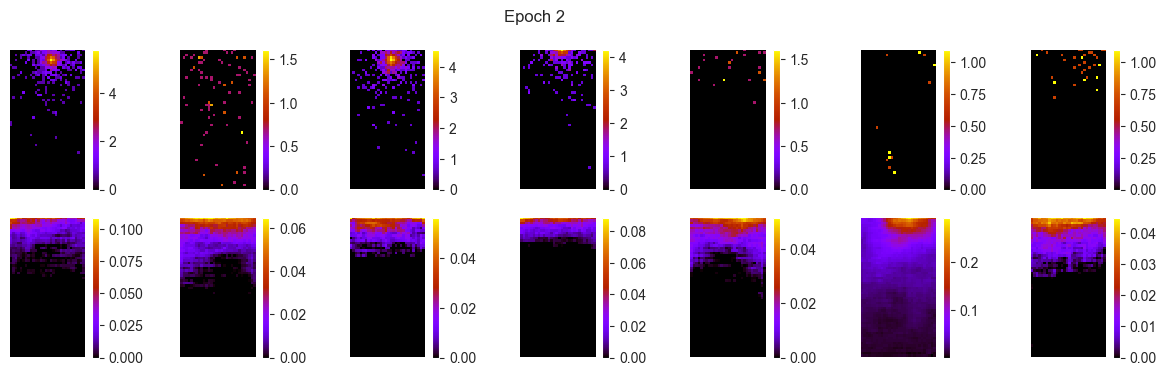

305/305 [==============================] - 3s 9ms/step
(9743, 56, 30)
ws mean 34.50 ch1 0.02 ch2 7.72 ch3 0.31 ch4 78.36 ch5 86.11 Time for epoch 2 is 29.031309604644775 sec
700 [Total loss: 32.50] [Recon_loss: 31.86] [KL loss: 0.90]
800 [Total loss: 46.79] [Recon_loss: 45.66] [KL loss: 1.62]
900 [Total loss: 42.17] [Recon_loss: 41.13] [KL loss: 1.49]


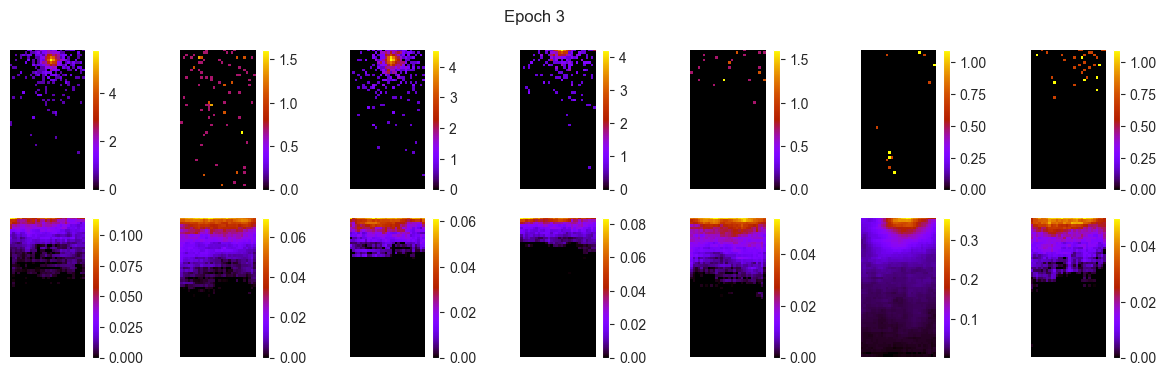

305/305 [==============================] - 3s 9ms/step
(9743, 56, 30)
ws mean 30.12 ch1 0.02 ch2 6.66 ch3 0.19 ch4 68.59 ch5 75.12 Time for epoch 3 is 30.271516799926758 sec
1000 [Total loss: 44.73] [Recon_loss: 43.70] [KL loss: 1.48]


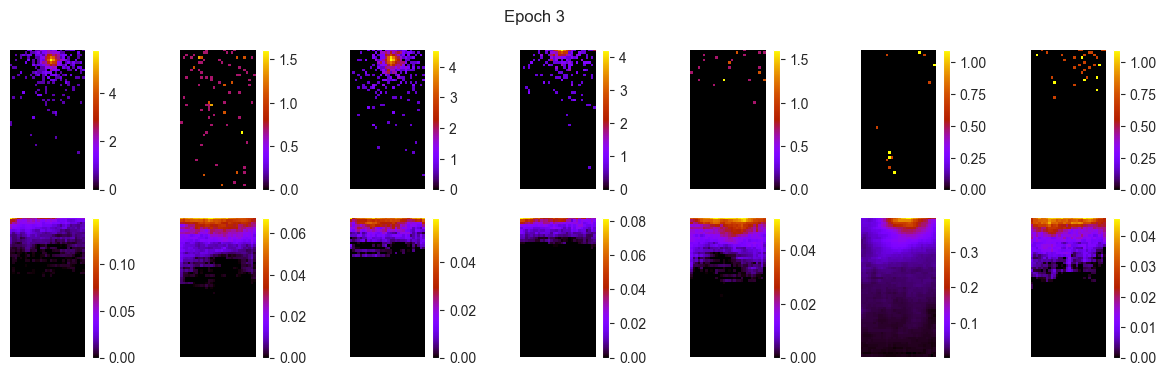

KeyboardInterrupt: 

In [24]:
def calculate_ws_ch(n_calc):
    ws= [0,0,0,0,0]
    for j in range(n_calc):
        z = np.random.normal(0,1,(x_test.shape[0],10))
        z_c = y_test
        results = generator.predict([z,z_c])
        results = np.exp(results)-1
        try:
            ch_gen = np.array(results).reshape(-1,56,30)
            ch_gen = pd.DataFrame(sum_channels_parallel(ch_gen)).values
            for i in range(5):
                ws[i] = ws[i] + wasserstein_distance(ch_org[:,i], ch_gen[:,i])
            ws =np.array(ws)
        except ValueError as e:
            print(e)

    ws = ws/n_calc
    print("ws mean",f'{ws.sum()/5:.2f}', end=" ")
    for n,score in enumerate(ws):
        print("ch"+str(n+1),f'{score:.2f}',end=" ")



####################### training ##############################
@tf.function
def train_step(batch,step):

    images, cond = batch
    step=step
    BATCH_SIZE = tf.shape(images)[0]

    #train vae
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = encoder([images, cond])
        reconstruction = generator([z, cond])
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(tf.reshape(images,(-1,56,30,1)), reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = 0.7 * kl_loss + reconstruction_loss
        # total_loss = reconstruction_loss
    grads = tape.gradient(total_loss, generator.trainable_weights+encoder.trainable_weights)
    vae_optimizer.apply_gradients(zip(grads, generator.trainable_weights+encoder.trainable_weights))

    return total_loss, reconstruction_loss, kl_loss


history = []
history_loss = []
def train(dataset, epochs):
    tf_step =tf.Variable(0, dtype=float)
    step=0
    generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])
    #print(calculate_ws_mae(3))
    for epoch in range(epochs):
        start = time.time()

        for batch in dataset:
            total_loss, reconstruction_loss, kl_loss =train_step(batch,tf_step)
            history.append([total_loss, reconstruction_loss, kl_loss])
            tf_step.assign_add(1)
            step = step+1

            if step%100==0:
                print("%d [Total loss: %.2f] [Recon_loss: %.2f] [KL loss: %.2f]"% (
                    step, total_loss, reconstruction_loss, kl_loss))

            if step%1000==0:
                generate_and_save_images(generator,
                               epoch,
                               [seed, seed_cond])

        generate_and_save_images(generator,
                                 epoch + 1,
                                 [seed, seed_cond]
                                 )

        # Save the model every epoch
        encoder.compile()
        generator.compile()
        encoder.save("../models/enc_"+NAME + "_"+ str(epoch) +".h5")
        generator.save("../models/gen_"+NAME + "_"+ str(epoch) +".h5")
        np.savez("../models/history_"+NAME+".npz",np.array(history))
        calculate_ws_ch(min(epoch//5+1,5))

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    return history


def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig, axs = plt.subplots(2, 7, figsize=(15, 4))
    fig.suptitle(f"Epoch {epoch}")
    for i in range(0, 14):
        if i < 7:
            x = x_test[20 + i].reshape(56, 30)
        else:
            x = predictions[i - 7].numpy().reshape(56, 30)
        #x[x<=0]=x.max()*-0.1
        im = axs[i // 7, i % 7].imshow(x, interpolation='none', cmap='gnuplot')
        axs[i // 7, i % 7].axis('off')
        fig.colorbar(im, ax=axs[i // 7, i % 7])
    # plt.savefig('../images/proton_photonsum_30/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


# ### Train model
history=train(dataset_with_cond, EPOCHS)

## Visualize losses

In [ ]:
import seaborn as sns

sns.set_context('notebook', font_scale = 1)

In [ ]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [ ]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [ ]:
a4_dims = (14, 5)
def print_loss(loss_values, loss_str):
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")
    plt.savefig(f"../images/proton_photonsum_30/{loss_str}_loss")

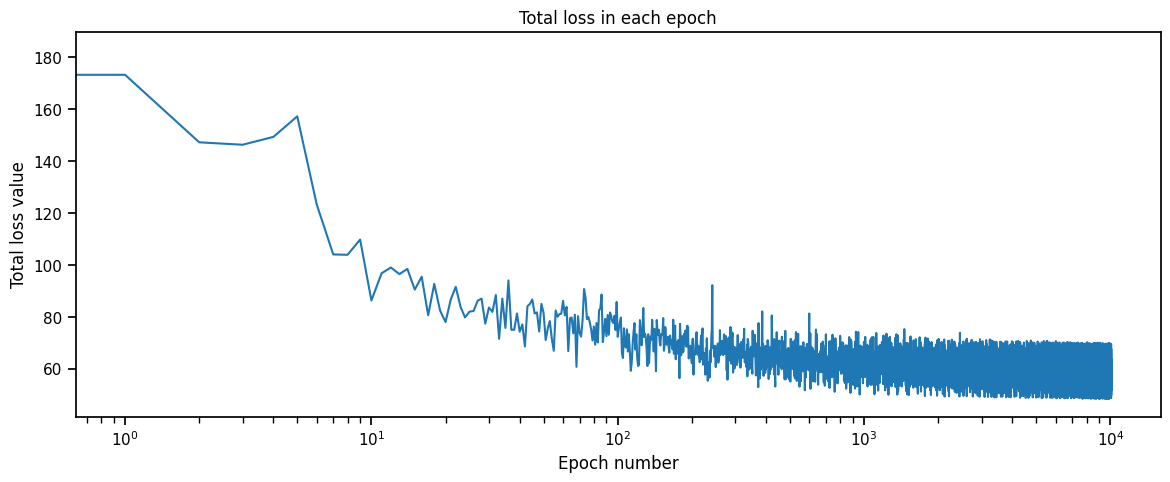

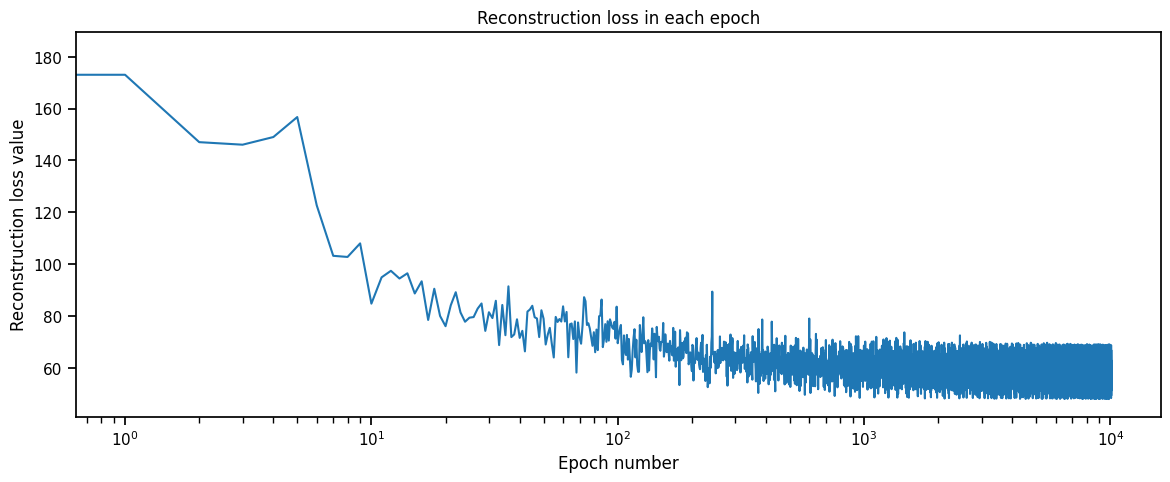

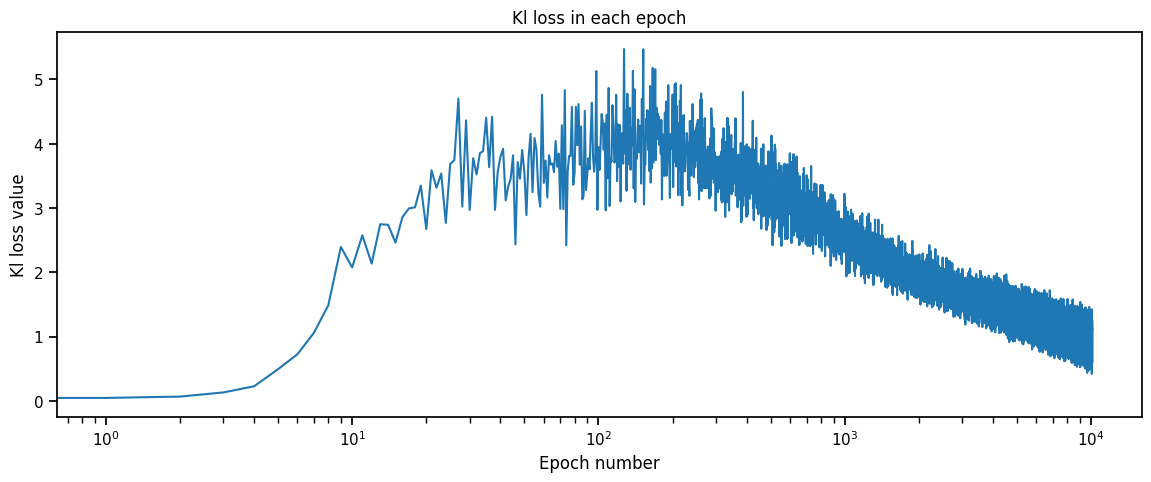

In [44]:
print_loss(total_loss, "Total")
print_loss(reconstruction_loss, "Reconstruction")
print_loss(kl_loss, "Kl")

In [105]:
# total_loss, reconstruction_loss, kl_loss
history_losses = np.array([[float(loss) for loss in losses] for losses in history])

In [106]:
total_loss = history_losses[:,0]
reconstruction_loss = history_losses[:,1]
kl_loss = history_losses[:,2]

In [112]:
a4_dims = (14, 5)

def print_loss(loss_values, loss_str):
    fig, ax = pyplot.subplots(figsize=a4_dims)
    sns.lineplot(loss_values)
    plt.xscale('log')
    ax.set_title(f"{loss_str} loss in each epoch")
    ax.set_xlabel("Epoch number")
    ax.set_ylabel(f"{loss_str} loss value")

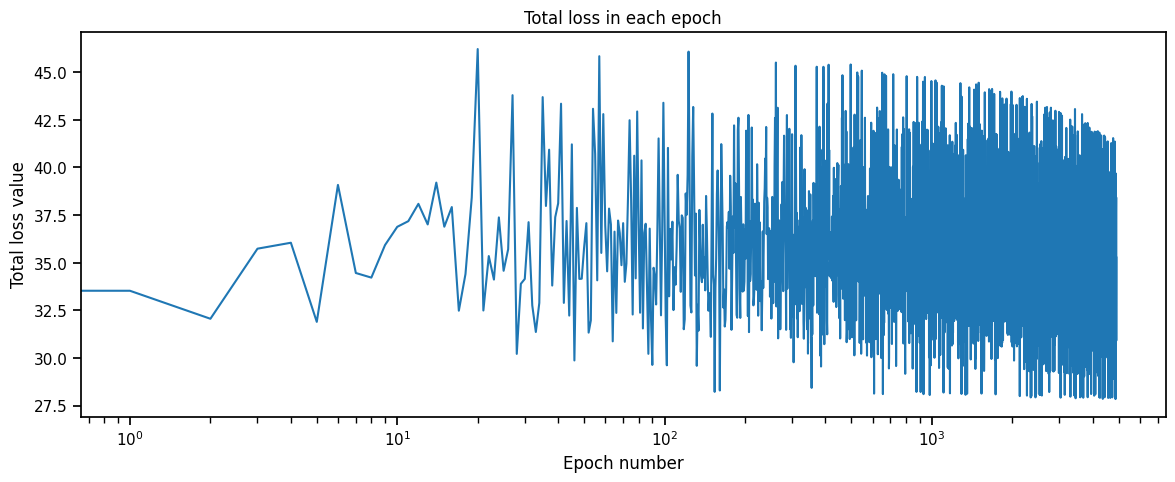

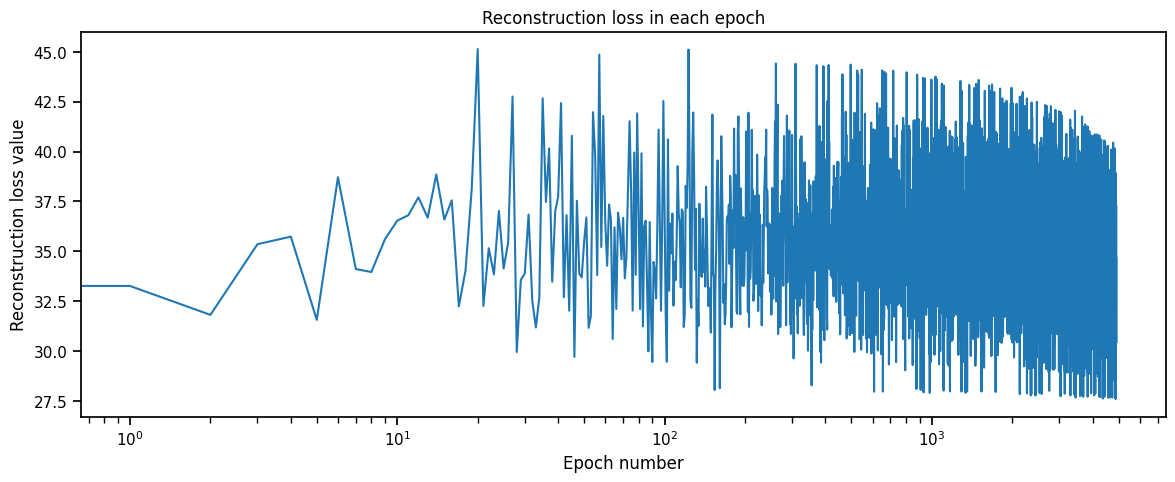

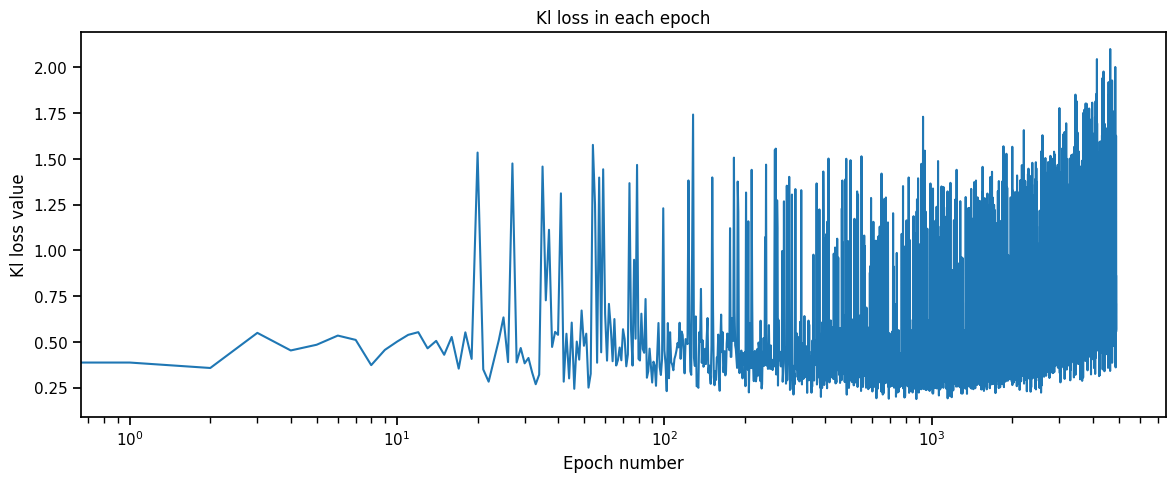

In [113]:
print_loss(total_loss[::10], "Total")
print_loss(reconstruction_loss[::10], "Reconstruction")
print_loss(kl_loss[::10], "Kl")